In [ ]:
!pip install lime shap tf-keras-vis tensorflow-addons --quiet

In [ ]:
# # Complete Malaria Detection using CNN + Transfer Learning + XAI
# # Designed for Google Colab/Kaggle Notebooks
# # IEEE Paper Implementation

# # Install required packages

# # Import libraries
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow.keras import layers, Model, optimizers
# from tensorflow.keras.applications import *
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# import cv2
# from lime import lime_image
# from lime.wrappers.scikit_image import SegmentationAlgorithm
# import shap
# from tf_keras_vis.gradcam import Gradcam
# from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
# from tf_keras_vis.utils.scores import CategoricalScore
# import time
# import warnings
# warnings.filterwarnings('ignore')

# # Set random seeds for reproducibility
# np.random.seed(42)
# tf.random.set_seed(42)

# class MalariaDetectionPipeline:
#     def __init__(self, data_dir):
#         self.data_dir = data_dir
#         self.img_size = (224, 224)
#         self.batch_size = 32
#         self.models = {}
#         self.results = {}
#         self.history = {}
        
#     def load_and_preprocess_data(self):
#         """Load and preprocess the malaria dataset"""
#         print("Loading and preprocessing data...")
        
#         # Create data generators
#         datagen = ImageDataGenerator(
#             rescale=1./255,
#             rotation_range=20,
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             horizontal_flip=True,
#             zoom_range=0.2,
#             validation_split=0.2
#         )
        
#         # Training data
#         self.train_generator = datagen.flow_from_directory(
#             self.data_dir,
#             target_size=self.img_size,
#             batch_size=self.batch_size,
#             class_mode='binary',
#             subset='training',
#             seed=42
#         )
        
#         # Validation data
#         self.val_generator = datagen.flow_from_directory(
#             self.data_dir,
#             target_size=self.img_size,
#             batch_size=self.batch_size,
#             class_mode='binary',
#             subset='validation',
#             seed=42
#         )
        
#         # Test data generator (no augmentation)
#         test_datagen = ImageDataGenerator(rescale=1./255)
#         self.test_generator = test_datagen.flow_from_directory(
#             self.data_dir,
#             target_size=self.img_size,
#             batch_size=self.batch_size,
#             class_mode='binary',
#             shuffle=False
#         )
        
#         print(f"Training samples: {self.train_generator.samples}")
#         print(f"Validation samples: {self.val_generator.samples}")
#         print(f"Classes: {self.train_generator.class_indices}")
        
#     def create_custom_cnn(self):
#         """Create custom CNN architecture (LeNet-inspired)"""
#         model = tf.keras.Sequential([
#             layers.Conv2D(6, (5, 5), activation='relu', input_shape=(*self.img_size, 3)),
#             layers.MaxPooling2D(2, 2),
#             layers.Conv2D(16, (5, 5), activation='relu'),
#             layers.MaxPooling2D(2, 2),
#             layers.Conv2D(32, (3, 3), activation='relu'),
#             layers.MaxPooling2D(2, 2),
#             layers.Flatten(),
#             layers.Dense(120, activation='relu'),
#             layers.Dropout(0.5),
#             layers.Dense(84, activation='relu'),
#             layers.Dropout(0.5),
#             layers.Dense(1, activation='sigmoid')
#         ])
#         return model
    
#     def create_transfer_learning_model(self, base_model_name, strategy='fine_tuning'):
#         """Create transfer learning models"""
#         # Get base model
#         base_models = {
#             'VGG16': VGG16,
#             'VGG19': VGG19,
#             'ResNet50': ResNet50,
#             'ResNet101': ResNet101,
#             'DenseNet121': DenseNet121,
#             'EfficientNetB0': EfficientNetB0,
#             'InceptionV3': InceptionV3,
#             'MobileNetV2': MobileNetV2
#         }
        
#         base_model = base_models[base_model_name](
#             weights='imagenet',
#             include_top=False,
#             input_shape=(*self.img_size, 3)
#         )
        
#         if strategy == 'feature_extraction':
#             base_model.trainable = False
#         elif strategy == 'fine_tuning':
#             base_model.trainable = True
#             # Fine-tune from this layer onwards
#             fine_tune_at = len(base_model.layers) // 2
#             for layer in base_model.layers[:fine_tune_at]:
#                 layer.trainable = False
        
#         # Add custom classifier
#         model = tf.keras.Sequential([
#             base_model,
#             layers.GlobalAveragePooling2D(),
#             layers.Dropout(0.5),
#             layers.Dense(128, activation='relu'),
#             layers.Dropout(0.5),
#             layers.Dense(1, activation='sigmoid')
#         ])
        
#         return model
    
#     def compile_and_train_model(self, model, model_name, epochs=50):
#         """Compile and train the model"""
#         print(f"\nTraining {model_name}...")
        
#         # Compile model
#         if 'fine_tuning' in model_name:
#             optimizer = optimizers.Adam(learning_rate=0.0001)
#         else:
#             optimizer = optimizers.Adam(learning_rate=0.001)
            
#         model.compile(
#             optimizer=optimizer,
#             loss='binary_crossentropy',
#             metrics=['accuracy', 'precision', 'recall']
#         )
        
#         # Callbacks
#         callbacks = [
#             EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
#             ModelCheckpoint(f'{model_name}_best.h5', save_best_only=True, monitor='val_accuracy')
#         ]
        
#         # Train model
#         start_time = time.time()
#         history = model.fit(
#             self.train_generator,
#             epochs=epochs,
#             validation_data=self.val_generator,
#             callbacks=callbacks,
#             verbose=1
#         )
#         training_time = time.time() - start_time
        
#         # Store model and history
#         self.models[model_name] = model
#         self.history[model_name] = history
        
#         # Evaluate model
#         test_loss, test_acc, test_precision, test_recall = model.evaluate(self.test_generator)
#         test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        
#         # Get predictions for ROC curve
#         predictions = model.predict(self.test_generator)
#         y_true = self.test_generator.classes
#         fpr, tpr, _ = roc_curve(y_true, predictions)
#         roc_auc = auc(fpr, tpr)
        
#         # Store results
#         self.results[model_name] = {
#             'test_accuracy': test_acc,
#             'test_precision': test_precision,
#             'test_recall': test_recall,
#             'test_f1': test_f1,
#             'roc_auc': roc_auc,
#             'training_time': training_time,
#             'parameters': model.count_params(),
#             'predictions': predictions.flatten(),
#             'y_true': y_true,
#             'fpr': fpr,
#             'tpr': tpr
#         }
        
#         print(f"Test Accuracy: {test_acc:.4f}")
#         print(f"Test F1-Score: {test_f1:.4f}")
#         print(f"ROC-AUC: {roc_auc:.4f}")
#         print(f"Training Time: {training_time:.2f}s")
#         print(f"Parameters: {model.count_params():,}")
        
#         return model, history
    
#     def run_all_experiments(self):
#         """Run all CNN experiments with different architectures and strategies"""
        
#         # Custom CNN
#         custom_cnn = self.create_custom_cnn()
#         self.compile_and_train_model(custom_cnn, 'Custom_CNN', epochs=30)
        
#         # Transfer Learning Models
#         # architectures = ['VGG16', 'ResNet50', 'DenseNet121', 'EfficientNetB0']
#         architectures = ['DenseNet121', 'EfficientNetB0']
#         strategies = ['feature_extraction', 'fine_tuning']
        
#         for arch in architectures:
#             for strategy in strategies:
#                 model_name = f"{arch}_{strategy}"
#                 try:
#                     model = self.create_transfer_learning_model(arch, strategy)
#                     epochs = 30 if strategy == 'feature_extraction' else 20
#                     self.compile_and_train_model(model, model_name, epochs=epochs)
#                 except Exception as e:
#                     print(f"Error training {model_name}: {e}")
#                     continue
    
#     def plot_training_history(self):
#         """Plot training history for all models"""
#         fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
#         for model_name, history in self.history.items():
#             # Accuracy
#             axes[0, 0].plot(history.history['accuracy'], label=f'{model_name}')
#             axes[0, 1].plot(history.history['val_accuracy'], label=f'{model_name}')
            
#             # Loss
#             axes[1, 0].plot(history.history['loss'], label=f'{model_name}')
#             axes[1, 1].plot(history.history['val_loss'], label=f'{model_name}')
        
#         axes[0, 0].set_title('Training Accuracy')
#         axes[0, 1].set_title('Validation Accuracy')
#         axes[1, 0].set_title('Training Loss')
#         axes[1, 1].set_title('Validation Loss')
        
#         for ax in axes.flat:
#             ax.legend()
#             ax.grid(True)
        
#         plt.tight_layout()
#         plt.show()
    
#     def plot_roc_curves(self):
#         """Plot ROC curves for all models"""
#         plt.figure(figsize=(10, 8))
        
#         for model_name, results in self.results.items():
#             plt.plot(results['fpr'], results['tpr'], 
#                     label=f"{model_name} (AUC = {results['roc_auc']:.3f})")
        
#         plt.plot([0, 1], [0, 1], 'k--', label='Random')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('ROC Curves for All Models')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
    
#     def create_results_table(self):
#         """Create comprehensive results table"""
#         results_data = []
        
#         for model_name, results in self.results.items():
#             results_data.append({
#                 'Model': model_name,
#                 'Accuracy': f"{results['test_accuracy']:.4f}",
#                 'Precision': f"{results['test_precision']:.4f}",
#                 'Recall': f"{results['test_recall']:.4f}",
#                 'F1-Score': f"{results['test_f1']:.4f}",
#                 'ROC-AUC': f"{results['roc_auc']:.4f}",
#                 'Parameters': f"{results['parameters']:,}",
#                 'Training Time (s)': f"{results['training_time']:.1f}"
#             })
        
#         df = pd.DataFrame(results_data)
#         df = df.sort_values('F1-Score', ascending=False)
        
#         print("\n" + "="*100)
#         print("COMPREHENSIVE RESULTS TABLE")
#         print("="*100)
#         print(df.to_string(index=False))
#         print("="*100)
        
#         return df

# class XAIAnalyzer:
#     """Explainable AI analyzer for malaria detection models"""
    
#     def __init__(self, model, test_generator):
#         self.model = model
#         self.test_generator = test_generator
        
#     def get_sample_images(self, num_samples=4):
#         """Get sample images for XAI analysis"""
#         # Reset generator
#         self.test_generator.reset()
        
#         images = []
#         labels = []
#         predictions = []
        
#         for _ in range(num_samples):
#             batch_x, batch_y = next(self.test_generator)
#             pred = self.model.predict(batch_x)
            
#             images.append(batch_x[0])
#             labels.append(int(batch_y[0]))
#             predictions.append(pred[0][0])
        
#         return np.array(images), np.array(labels), np.array(predictions)
    
#     def apply_gradcam(self, images, layer_name=None):
#         """Apply Grad-CAM visualization"""
#         print("Applying Grad-CAM...")
        
#         # Find the last convolutional layer if not specified
#         if layer_name is None:
#             for layer in reversed(self.model.layers):
#                 if len(layer.output_shape) == 4:
#                     layer_name = layer.name
#                     break
        
#         gradcam = Gradcam(self.model, model_modifier=ReplaceToLinear(), clone=False)
        
#         heatmaps = []
#         for img in images:
#             img_input = np.expand_dims(img, axis=0)
#             score = CategoricalScore([1])  # For binary classification
            
#             heatmap = gradcam(score, img_input, penultimate_layer=layer_name)
#             heatmaps.append(heatmap[0])
        
#         return np.array(heatmaps)
    
#     def apply_lime(self, images, num_features=100):
#         """Apply LIME visualization"""
#         print("Applying LIME...")
        
#         def model_predict(x):
#             return self.model.predict(x)
        
#         explainer = lime_image.LimeImageExplainer()
#         explanations = []
        
#         for img in images:
#             explanation = explainer.explain_instance(
#                 img,
#                 model_predict,
#                 top_labels=2,
#                 hide_color=0,
#                 num_samples=1000,
#                 num_features=num_features,
#                 random_seed=42
#             )
#             explanations.append(explanation)
        
#         return explanations
    
#     def apply_shap(self, images, background_samples=50):
#         """Apply SHAP visualization"""
#         print("Applying SHAP...")
        
#         # Create background dataset
#         background = images[:background_samples] if len(images) >= background_samples else images
        
#         # Create SHAP explainer
#         explainer = shap.DeepExplainer(self.model, background)
        
#         # Calculate SHAP values
#         shap_values = explainer.shap_values(images[:4])  # Limit to 4 samples for visualization
        
#         return shap_values
    
#     def visualize_explanations(self, images, labels, predictions, heatmaps, lime_explanations, shap_values):
#         """Create comprehensive visualization of all XAI methods"""
        
#         fig, axes = plt.subplots(4, 4, figsize=(16, 16))
#         class_names = ['Uninfected', 'Parasitized']
        
#         for i in range(min(4, len(images))):
#             # Original image
#             axes[i, 0].imshow(images[i])
#             axes[i, 0].set_title(f'Original\nTrue: {class_names[labels[i]]}\nPred: {class_names[int(predictions[i] > 0.5)]}\nConf: {predictions[i]:.3f}')
#             axes[i, 0].axis('off')
            
#             # Grad-CAM
#             axes[i, 1].imshow(images[i])
#             axes[i, 1].imshow(heatmaps[i], alpha=0.4, cmap='jet')
#             axes[i, 1].set_title('Grad-CAM')
#             axes[i, 1].axis('off')
            
#             # LIME
#             temp, mask = lime_explanations[i].get_image_and_mask(
#                 lime_explanations[i].top_labels[0],
#                 positive_only=False,
#                 num_features=10,
#                 hide_rest=False
#             )
#             axes[i, 2].imshow(temp)
#             axes[i, 2].set_title('LIME')
#             axes[i, 2].axis('off')
            
#             # SHAP
#             if shap_values is not None and i < len(shap_values[0]):
#                 shap_img = shap_values[0][i]
#                 if len(shap_img.shape) == 3:
#                     shap_img = np.sum(shap_img, axis=2)
#                 axes[i, 3].imshow(images[i])
#                 axes[i, 3].imshow(shap_img, alpha=0.4, cmap='RdBu')
#                 axes[i, 3].set_title('SHAP')
#             else:
#                 axes[i, 3].text(0.5, 0.5, 'SHAP\nNot Available', 
#                                ha='center', va='center', transform=axes[i, 3].transAxes)
#             axes[i, 3].axis('off')
        
#         plt.suptitle('Explainable AI Visualization Comparison', fontsize=16)
#         plt.tight_layout()
#         plt.show()

# # Main execution function
# def main():
#     """Main function to run the complete pipeline"""
    
#     print("="*80)
#     print("MALARIA DETECTION USING CNN + TRANSFER LEARNING + XAI")
#     print("IEEE Paper Implementation")
#     print("="*80)
    
#     # Set data directory - MODIFY THIS PATH ACCORDING TO YOUR SETUP
#     # For Google Colab: upload your data and use the path
#     # For Kaggle: use '/kaggle/input/your-dataset-name/'
    
#     DATA_DIR = '/kaggle/input/malaria-dataset/cell_images'  # Modify this path
    
#     # Initialize pipeline
#     pipeline = MalariaDetectionPipeline(DATA_DIR)
    
#     # Load and preprocess data
#     pipeline.load_and_preprocess_data()
    
#     # Run all experiments
#     pipeline.run_all_experiments()
    
#     # Plot results
#     pipeline.plot_training_history()
#     pipeline.plot_roc_curves()
    
#     # Create results table
#     results_df = pipeline.create_results_table()
    
#     # Get best model for XAI analysis
#     best_model_name = results_df.iloc[0]['Model']
#     best_model = pipeline.models[best_model_name]
    
#     print(f"\nBest performing model: {best_model_name}")
#     print(f"Best F1-Score: {results_df.iloc[0]['F1-Score']}")
    
#     # XAI Analysis
#     print("\n" + "="*50)
#     print("EXPLAINABLE AI ANALYSIS")
#     print("="*50)
    
#     xai_analyzer = XAIAnalyzer(best_model, pipeline.test_generator)
    
#     # Get sample images
#     sample_images, sample_labels, sample_predictions = xai_analyzer.get_sample_images()
    
#     # Apply XAI methods
#     try:
#         heatmaps = xai_analyzer.apply_gradcam(sample_images)
#     except Exception as e:
#         print(f"Grad-CAM error: {e}")
#         heatmaps = np.zeros_like(sample_images)
    
#     try:
#         lime_explanations = xai_analyzer.apply_lime(sample_images)
#     except Exception as e:
#         print(f"LIME error: {e}")
#         lime_explanations = [None] * len(sample_images)
    
#     try:
#         shap_values = xai_analyzer.apply_shap(sample_images)
#     except Exception as e:
#         print(f"SHAP error: {e}")
#         shap_values = None
    
#     # Visualize explanations
#     xai_analyzer.visualize_explanations(
#         sample_images, sample_labels, sample_predictions,
#         heatmaps, lime_explanations, shap_values
#     )
    
#     print("\n" + "="*80)
#     print("EXPERIMENT COMPLETED SUCCESSFULLY!")
#     print("="*80)
    
#     return pipeline, results_df, xai_analyzer

# # Usage Instructions:
# """
# 1. Upload your malaria dataset to Google Colab/Kaggle
# 2. Organize it as:
#    cell_images/
#    ├── Parasitized/
#    │   ├── image1.png
#    │   └── ...
#    └── Uninfected/
#        ├── image1.png
#        └── ...

# 3. Update the DATA_DIR variable in main() function
# 4. Run the script: main()
# """

# if __name__ == "__main__":
#     # Uncomment the next line to run
#     pipeline, results_df, xai_analyzer = main()
#     pass

2025-12-29 14:03:04.042159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767016984.219945      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767016984.271643      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


QUICK ENSEMBLE TEST
Creating data generators...
Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.
✓ Training samples: 22048
✓ Validation samples: 5510
✓ Test samples: 27558

LOADING ALL MODELS FOR ENSEMBLE


I0000 00:00:1767017009.928946      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✓ Loaded Custom_CNN from /kaggle/input/malaria-complete-models/res
✓ Loaded VGG16_feature_extraction from /kaggle/input/malaria-complete-models/res
✓ Loaded VGG16_fine_tuning from /kaggle/input/malaria-complete-models/res
✓ Loaded ResNet50_feature_extraction from /kaggle/input/malaria-complete-models/res
✓ Loaded ResNet50_fine_tuning from /kaggle/input/malaria-complete-models/res
✓ Loaded DenseNet121_feature_extraction from /kaggle/input/malaria-complete-models/res
✓ Loaded DenseNet121_fine_tuning from /kaggle/input/malaria-complete-models/res
✓ Loaded EfficientNetB0_feature_extraction from /kaggle/input/malaria-complete-models/res
✓ Loaded EfficientNetB0_fine_tuning from /kaggle/input/malaria-complete-models/res
✗ Error loading MobileNetV3_feature_extraction_best from /kaggle/input/malaria-complete-models/res: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)
✗ Could not find Mob

I0000 00:00:1767017028.173323     117 service.cc:148] XLA service 0x7f951c002b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767017028.173956     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767017028.275098     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1767017029.420391     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  ✓ Custom_CNN: Accuracy = 0.9563
  ✓ VGG16_feature_extraction: Accuracy = 0.8879
  ✓ VGG16_fine_tuning: Accuracy = 0.9693
  ✓ ResNet50_feature_extraction: Accuracy = 0.5190
  ✓ ResNet50_fine_tuning: Accuracy = 0.9513
  ✓ DenseNet121_feature_extraction: Accuracy = 0.9152
  ✓ DenseNet121_fine_tuning: Accuracy = 0.9744
  ✓ EfficientNetB0_feature_extraction: Accuracy = 0.5000
  ✓ EfficientNetB0_fine_tuning: Accuracy = 0.5000
  ✓ Xception_feature_extraction: Accuracy = 0.9317
  ✓ Xception_fine_tuning: Accuracy = 0.9780

TOP 7 MODELS SELECTED FOR ENSEMBLE:
1. Xception_fine_tuning: 0.9780
2. DenseNet121_fine_tuning: 0.9744
3. VGG16_fine_tuning: 0.9693
4. Custom_CNN: 0.9563
5. ResNet50_fine_tuning: 0.9513
6. Xception_feature_extraction: 0.9317
7. DenseNet121_feature_extraction: 0.9152

Performing majority voting on 27558 samples...

ENSEMBLE RESULTS:
Ensemble Accuracy:        0.9671
Best Individual Model:    Xception_fine_tuning
Best Individual Accuracy: 0.9780
Improvement:              -0.01

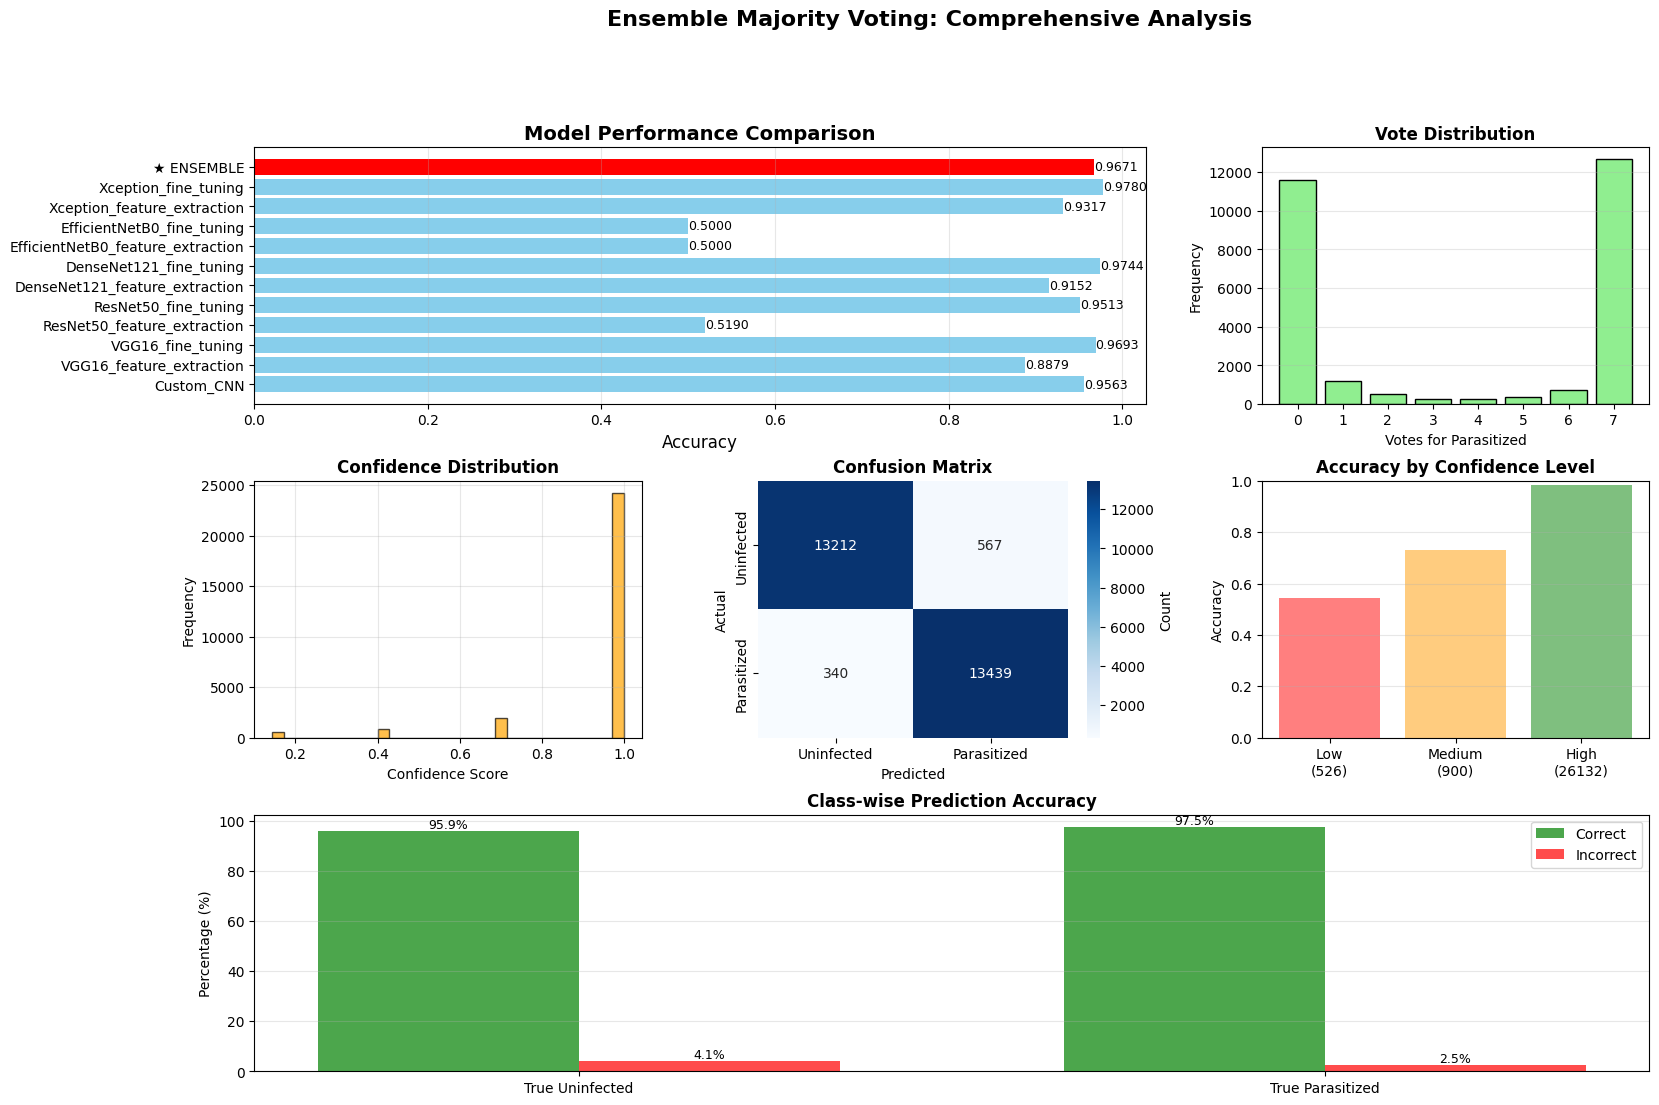

In [1]:
# Optimized Malaria Detection: Train Only New Models + Ensemble with Existing
# IEEE Paper Implementation - Resource Efficient Version

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

class OptimizedMalariaEnsemble:
    def __init__(self, data_dir, existing_models_dir='/kaggle/input/malaria-complete-models/res'):
        self.data_dir = data_dir
        self.existing_models_dir = existing_models_dir
        self.img_size = (224, 224)
        self.batch_size = 32
        self.class_names = ['Uninfected', 'Parasitized']
        
    def load_data_generators(self):
        """Create data generators"""
        print("Creating data generators...")
        
        # Training data with augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=25,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            brightness_range=[0.8, 1.2],
            validation_split=0.2
        )
        
        # Test data without augmentation
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        self.train_generator = train_datagen.flow_from_directory(
            self.data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='training',
            seed=42
        )
        
        self.val_generator = train_datagen.flow_from_directory(
            self.data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='validation',
            seed=42
        )
        
        self.test_generator = test_datagen.flow_from_directory(
            self.data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )
        
        print(f"✓ Training samples: {self.train_generator.samples}")
        print(f"✓ Validation samples: {self.val_generator.samples}")
        print(f"✓ Test samples: {self.test_generator.samples}")
        
    def create_mobilenet_v3(self, strategy='fine_tuning'):
        """Create MobileNetV3Large model"""
        try:
            from tensorflow.keras.applications import MobileNetV3Large
            base_model = MobileNetV3Large(
                weights='imagenet',
                include_top=False,
                input_shape=(*self.img_size, 3)
            )
        except:
            # Fallback to MobileNetV2 if V3 not available
            print("MobileNetV3 not available, using MobileNetV2")
            base_model = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=(*self.img_size, 3)
            )
        
        if strategy == 'feature_extraction':
            base_model.trainable = False
        elif strategy == 'fine_tuning':
            base_model.trainable = True
            fine_tune_at = len(base_model.layers) // 2
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
        
        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ], name=f'MobileNetV3_{strategy}')
        
        return model
    
    def create_inception_resnet_v2(self, strategy='fine_tuning'):
        """Create InceptionResNetV2 model"""
        base_model = InceptionResNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )
        
        if strategy == 'feature_extraction':
            base_model.trainable = False
        elif strategy == 'fine_tuning':
            base_model.trainable = True
            fine_tune_at = len(base_model.layers) // 2
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
        
        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.6),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ], name=f'InceptionResNetV2_{strategy}')
        
        return model
    
    def create_xception(self, strategy='fine_tuning'):
        """Create Xception model"""
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )
        
        if strategy == 'feature_extraction':
            base_model.trainable = False
        elif strategy == 'fine_tuning':
            base_model.trainable = True
            fine_tune_at = len(base_model.layers) // 2
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
        
        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ], name=f'Xception_{strategy}')
        
        return model
    
    def train_new_models_only(self):
        """Train ONLY the 3 new models (not the existing ones)"""
        print("="*80)
        print("TRAINING NEW MODELS ONLY (MobileNetV3, InceptionResNetV2, Xception)")
        print("="*80)
        
        new_models = {
            # 'MobileNetV3': self.create_mobilenet_v3,
            # 'InceptionResNetV2': self.create_inception_resnet_v2,
            'Xception': self.create_xception
        }
        
        strategies = ['feature_extraction', 'fine_tuning']
        training_results = {}
        
        for arch_name, model_func in new_models.items():
            for strategy in strategies:
                model_name = f"{arch_name}_{strategy}"
                print(f"\n{'='*60}")
                print(f"Training {model_name}...")
                print(f"{'='*60}")
                
                try:
                    # Create model
                    model = model_func(strategy)
                    
                    # Compile
                    if strategy == 'fine_tuning':
                        optimizer = optimizers.Adam(learning_rate=0.0001)
                        epochs = 25
                    else:
                        optimizer = optimizers.Adam(learning_rate=0.001)
                        epochs = 30
                    
                    model.compile(
                        optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['accuracy', 
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall')]
                    )
                    
                    print(f"Total parameters: {model.count_params():,}")
                    
                    # Callbacks
                    callbacks = [
                        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001, verbose=1),
                        ModelCheckpoint(f'{model_name}_best.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
                    ]
                    
                    # Train
                    import time
                    start_time = time.time()
                    
                    history = model.fit(
                        self.train_generator,
                        epochs=epochs,
                        validation_data=self.val_generator,
                        callbacks=callbacks,
                        verbose=1
                    )
                    
                    training_time = time.time() - start_time
                    
                    # Evaluate
                    print(f"\nEvaluating {model_name} on test set...")
                    test_results = model.evaluate(self.test_generator, verbose=0)
                    
                    test_loss = test_results[0]
                    test_acc = test_results[1]
                    test_precision = test_results[2]
                    test_recall = test_results[3]
                    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
                    
                    training_results[model_name] = {
                        'accuracy': test_acc,
                        'precision': test_precision,
                        'recall': test_recall,
                        'f1_score': test_f1,
                        'loss': test_loss,
                        'training_time': training_time,
                        'parameters': model.count_params()
                    }
                    
                    print(f"\n{'='*60}")
                    print(f"RESULTS FOR {model_name}:")
                    print(f"  Test Accuracy:  {test_acc:.4f}")
                    print(f"  Test Precision: {test_precision:.4f}")
                    print(f"  Test Recall:    {test_recall:.4f}")
                    print(f"  Test F1-Score:  {test_f1:.4f}")
                    print(f"  Training Time:  {training_time:.1f}s ({training_time/60:.1f} min)")
                    print(f"  Parameters:     {model.count_params():,}")
                    print(f"{'='*60}")
                    
                except Exception as e:
                    print(f"✗ Error training {model_name}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
        
        # Summary of new models
        print(f"\n{'='*80}")
        print("NEW MODELS TRAINING SUMMARY")
        print(f"{'='*80}")
        
        if training_results:
            df_results = pd.DataFrame(training_results).T
            df_results = df_results.sort_values('f1_score', ascending=False)
            print(df_results.to_string())
        
        return training_results
    
    def load_all_models(self, current_dir='.'):
        """Load all models: existing + newly trained"""
        print(f"\n{'='*80}")
        print("LOADING ALL MODELS FOR ENSEMBLE")
        print(f"{'='*80}")
        
        all_model_names = [
            'Custom_CNN_best',
            'VGG16_feature_extraction_best',
            'VGG16_fine_tuning_best',
            'ResNet50_feature_extraction_best',
            'ResNet50_fine_tuning_best',
            'DenseNet121_feature_extraction_best',
            'DenseNet121_fine_tuning_best',
            'EfficientNetB0_feature_extraction_best',
            'EfficientNetB0_fine_tuning_best',
            'MobileNetV3_feature_extraction_best',
            'MobileNetV3_fine_tuning_best',
            'InceptionResNetV2_feature_extraction_best',
            'InceptionResNetV2_fine_tuning_best',
            'Xception_feature_extraction_best',
            'Xception_fine_tuning_best'
        ]
        
        loaded_models = {}
        
        # Try loading from multiple locations
        search_paths = [
            current_dir,
            self.existing_models_dir,
            '/kaggle/working'
        ]
        
        for model_name in all_model_names:
            model_filename = f'{model_name}.h5' if not model_name.endswith('.h5') else model_name
            loaded = False
            
            for search_path in search_paths:
                if not os.path.exists(search_path):
                    continue
                    
                model_path = os.path.join(search_path, model_filename)
                
                if os.path.exists(model_path):
                    try:
                        model = tf.keras.models.load_model(model_path, compile=False)
                        
                        # Recompile for consistency
                        model.compile(
                            optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy']
                        )
                        
                        clean_name = model_name.replace('_best', '')
                        loaded_models[clean_name] = model
                        print(f"✓ Loaded {clean_name} from {search_path}")
                        loaded = True
                        break
                    except Exception as e:
                        print(f"✗ Error loading {model_name} from {search_path}: {e}")
                        continue
            
            if not loaded:
                print(f"✗ Could not find {model_name} in any search path")
        
        print(f"\n{'='*80}")
        print(f"Successfully loaded {len(loaded_models)} models")
        print(f"{'='*80}")
        
        return loaded_models
    
    def majority_voting_ensemble(self, models, test_generator, top_n=7):
        """Implement majority voting with detailed analysis"""
        print(f"\n{'='*80}")
        print(f"MAJORITY VOTING ENSEMBLE ANALYSIS (Top {top_n} Models)")
        print(f"{'='*80}")
        
        test_generator.reset()
        
        # Collect predictions
        model_predictions = {}
        model_performance = {}
        
        print("\nCollecting predictions from all models...")
        for model_name, model in models.items():
            try:
                predictions = model.predict(test_generator, verbose=0)
                binary_predictions = (predictions > 0.5).astype(int).flatten()
                y_true = test_generator.classes
                accuracy = accuracy_score(y_true, binary_predictions)
                
                model_predictions[model_name] = {
                    'probabilities': predictions.flatten(),
                    'binary_predictions': binary_predictions,
                    'accuracy': accuracy
                }
                model_performance[model_name] = accuracy
                
                print(f"  ✓ {model_name}: Accuracy = {accuracy:.4f}")
                test_generator.reset()
                
            except Exception as e:
                print(f"  ✗ Error with {model_name}: {e}")
                continue
        
        # Select top N models
        sorted_models = sorted(model_performance.items(), key=lambda x: x[1], reverse=True)
        top_models = [name for name, _ in sorted_models[:min(top_n, len(sorted_models))]]
        
        print(f"\n{'='*60}")
        print(f"TOP {len(top_models)} MODELS SELECTED FOR ENSEMBLE:")
        print(f"{'='*60}")
        for i, model_name in enumerate(top_models, 1):
            print(f"{i}. {model_name}: {model_performance[model_name]:.4f}")
        
        # Perform majority voting
        n_samples = len(test_generator.classes)
        voting_results = []
        ensemble_predictions = []
        
        print(f"\nPerforming majority voting on {n_samples} samples...")
        
        for i in range(n_samples):
            votes = []
            model_votes = {}
            vote_probs = []
            
            for model_name in top_models:
                if model_name in model_predictions:
                    vote = model_predictions[model_name]['binary_predictions'][i]
                    prob = model_predictions[model_name]['probabilities'][i]
                    votes.append(vote)
                    vote_probs.append(prob)
                    model_votes[model_name] = {
                        'vote': self.class_names[vote],
                        'confidence': float(prob) if vote == 1 else float(1 - prob)
                    }
            
            if len(votes) > 0:
                majority_vote = 1 if sum(votes) > len(votes) / 2 else 0
                ensemble_predictions.append(majority_vote)
                
                # Calculate ensemble confidence
                confidence = abs(sum(votes) - len(votes)/2) / (len(votes)/2) if len(votes) > 1 else 1.0
                
                voting_results.append({
                    'sample_id': i,
                    'true_label': test_generator.classes[i],
                    'true_label_name': self.class_names[test_generator.classes[i]],
                    'ensemble_prediction': majority_vote,
                    'ensemble_prediction_name': self.class_names[majority_vote],
                    'votes_for_parasitized': sum(votes),
                    'votes_for_uninfected': len(votes) - sum(votes),
                    'total_votes': len(votes),
                    'confidence': confidence,
                    'individual_votes': model_votes,
                    'correct': test_generator.classes[i] == majority_vote
                })
        
        ensemble_predictions = np.array(ensemble_predictions)
        ensemble_accuracy = accuracy_score(test_generator.classes, ensemble_predictions)
        
        print(f"\n{'='*80}")
        print("ENSEMBLE RESULTS:")
        print(f"{'='*80}")
        print(f"Ensemble Accuracy:        {ensemble_accuracy:.4f}")
        print(f"Best Individual Model:    {sorted_models[0][0]}")
        print(f"Best Individual Accuracy: {sorted_models[0][1]:.4f}")
        print(f"Improvement:              {ensemble_accuracy - sorted_models[0][1]:+.4f}")
        print(f"{'='*80}")
        
        return voting_results, ensemble_predictions, top_models, model_predictions
    
    def analyze_voting_patterns(self, voting_results, top_models):
        """Detailed voting pattern analysis"""
        print(f"\n{'='*80}")
        print("DETAILED VOTING PATTERN ANALYSIS")
        print(f"{'='*80}")
        
        df_votes = pd.DataFrame(voting_results)
        total = len(df_votes)
        correct = sum(df_votes['correct'])
        
        print(f"\nOverall Statistics:")
        print(f"  Total samples:           {total}")
        print(f"  Correct predictions:     {correct} ({correct/total*100:.2f}%)")
        print(f"  Incorrect predictions:   {total-correct} ({(total-correct)/total*100:.2f}%)")
        
        # Confidence analysis
        high_conf = df_votes[df_votes['confidence'] >= 0.7]
        med_conf = df_votes[(df_votes['confidence'] >= 0.3) & (df_votes['confidence'] < 0.7)]
        low_conf = df_votes[df_votes['confidence'] < 0.3]
        
        print(f"\nConfidence Distribution:")
        print(f"  High (≥70%):   {len(high_conf):4d} ({len(high_conf)/total*100:5.2f}%) - Accuracy: {sum(high_conf['correct'])/len(high_conf)*100 if len(high_conf)>0 else 0:.2f}%")
        print(f"  Medium (30-70%): {len(med_conf):4d} ({len(med_conf)/total*100:5.2f}%) - Accuracy: {sum(med_conf['correct'])/len(med_conf)*100 if len(med_conf)>0 else 0:.2f}%")
        print(f"  Low (<30%):    {len(low_conf):4d} ({len(low_conf)/total*100:5.2f}%) - Accuracy: {sum(low_conf['correct'])/len(low_conf)*100 if len(low_conf)>0 else 0:.2f}%")
        
        # Unanimous vs split
        unanimous = df_votes[df_votes['confidence'] == 1.0]
        split = df_votes[df_votes['confidence'] < 1.0]
        
        print(f"\nDecision Consensus:")
        print(f"  Unanimous: {len(unanimous):4d} ({len(unanimous)/total*100:5.2f}%) - Accuracy: {sum(unanimous['correct'])/len(unanimous)*100 if len(unanimous)>0 else 0:.2f}%")
        print(f"  Split:     {len(split):4d} ({len(split)/total*100:5.2f}%) - Accuracy: {sum(split['correct'])/len(split)*100 if len(split)>0 else 0:.2f}%")
        
        # Vote distribution
        print(f"\nVote Distribution for Parasitized:")
        vote_dist = df_votes['votes_for_parasitized'].value_counts().sort_index()
        for votes, count in vote_dist.items():
            print(f"  {votes} votes: {count:4d} samples ({count/total*100:5.2f}%)")
        
        return df_votes
    
    def visualize_ensemble_results(self, voting_results, top_models, model_predictions):
        """Comprehensive visualizations"""
        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Model Performance Comparison
        ax1 = fig.add_subplot(gs[0, :2])
        model_accs = {name: pred['accuracy'] for name, pred in model_predictions.items()}
        ensemble_acc = sum(r['correct'] for r in voting_results) / len(voting_results)
        model_accs['★ ENSEMBLE'] = ensemble_acc
        
        models = list(model_accs.keys())
        accuracies = list(model_accs.values())
        colors = ['skyblue'] * (len(models)-1) + ['red']
        
        bars = ax1.barh(models, accuracies, color=colors)
        ax1.set_xlabel('Accuracy', fontsize=12)
        ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax1.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{width:.4f}', ha='left', va='center', fontsize=9)
        
        # 2. Voting Distribution
        ax2 = fig.add_subplot(gs[0, 2])
        df_votes = pd.DataFrame(voting_results)
        vote_counts = df_votes['votes_for_parasitized'].value_counts().sort_index()
        ax2.bar(vote_counts.index, vote_counts.values, color='lightgreen', edgecolor='black')
        ax2.set_xlabel('Votes for Parasitized', fontsize=10)
        ax2.set_ylabel('Frequency', fontsize=10)
        ax2.set_title('Vote Distribution', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Confidence Distribution
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.hist(df_votes['confidence'], bins=30, color='orange', alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Confidence Score', fontsize=10)
        ax3.set_ylabel('Frequency', fontsize=10)
        ax3.set_title('Confidence Distribution', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # 4. Confusion Matrix
        ax4 = fig.add_subplot(gs[1, 1])
        y_true = [r['true_label'] for r in voting_results]
        y_pred = [r['ensemble_prediction'] for r in voting_results]
        cm = confusion_matrix(y_true, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.class_names, yticklabels=self.class_names, 
                    ax=ax4, cbar_kws={'label': 'Count'})
        ax4.set_xlabel('Predicted', fontsize=10)
        ax4.set_ylabel('Actual', fontsize=10)
        ax4.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
        
        # 5. Accuracy by Confidence Level
        ax5 = fig.add_subplot(gs[1, 2])
        conf_bins = [(0, 0.3, 'Low'), (0.3, 0.7, 'Medium'), (0.7, 1.01, 'High')]
        conf_accs = []
        conf_labels = []
        
        for low, high, label in conf_bins:
            subset = df_votes[(df_votes['confidence'] >= low) & (df_votes['confidence'] < high)]
            if len(subset) > 0:
                acc = sum(subset['correct']) / len(subset)
                conf_accs.append(acc)
                conf_labels.append(f'{label}\n({len(subset)})')
        
        ax5.bar(conf_labels, conf_accs, color=['#ff7f7f', '#ffcc7f', '#7fbf7f'])
        ax5.set_ylabel('Accuracy', fontsize=10)
        ax5.set_title('Accuracy by Confidence Level', fontsize=12, fontweight='bold')
        ax5.set_ylim([0, 1])
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 6. Class-wise Performance
        ax6 = fig.add_subplot(gs[2, :])
        
        # Calculate metrics for each class
        for class_idx, class_name in enumerate(self.class_names):
            class_samples = df_votes[df_votes['true_label'] == class_idx]
            if len(class_samples) > 0:
                acc = sum(class_samples['correct']) / len(class_samples)
                avg_conf = class_samples['confidence'].mean()
                print(f"\nClass '{class_name}' Performance:")
                print(f"  Accuracy: {acc:.4f}")
                print(f"  Avg Confidence: {avg_conf:.4f}")
                print(f"  Samples: {len(class_samples)}")
        
        # Show confusion percentages
        cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100
        
        categories = ['True Uninfected', 'True Parasitized']
        x = np.arange(len(categories))
        width = 0.35
        
        correct = [cm_percent[0, 0], cm_percent[1, 1]]
        incorrect = [cm_percent[0, 1], cm_percent[1, 0]]
        
        bars1 = ax6.bar(x - width/2, correct, width, label='Correct', color='green', alpha=0.7)
        bars2 = ax6.bar(x + width/2, incorrect, width, label='Incorrect', color='red', alpha=0.7)
        
        ax6.set_ylabel('Percentage (%)', fontsize=10)
        ax6.set_title('Class-wise Prediction Accuracy', fontsize=12, fontweight='bold')
        ax6.set_xticks(x)
        ax6.set_xticklabels(categories)
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax6.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        plt.suptitle('Ensemble Majority Voting: Comprehensive Analysis', 
                     fontsize=16, fontweight='bold', y=0.995)
        plt.show()
    
    def show_sample_predictions(self, voting_results, n_samples=15):
        """Display detailed sample predictions"""
        print(f"\n{'='*100}")
        print(f"SAMPLE PREDICTION DETAILS (First {n_samples} cases)")
        print(f"{'='*100}")
        
        for i in range(min(n_samples, len(voting_results))):
            result = voting_results[i]
            
            status = '✓ CORRECT' if result['correct'] else '✗ WRONG'
            print(f"\nSample #{i+1} - {status}")
            print(f"{'─'*90}")
            print(f"  Ground Truth:        {result['true_label_name']}")
            print(f"  Ensemble Prediction: {result['ensemble_prediction_name']}")
            print(f"  Vote Count:          {result['votes_for_parasitized']} Parasitized / {result['votes_for_uninfected']} Uninfected")
            print(f"  Confidence:          {result['confidence']:.3f}")
            
            print(f"\n  Individual Model Votes:")
            for model_name, vote_info in result['individual_votes'].items():
                print(f"    • {model_name:35s}: {vote_info['vote']:12s} (confidence: {vote_info['confidence']:.3f})")
            print(f"{'─'*90}")
    
    def save_detailed_report(self, voting_results, top_models, model_predictions):
        """Save detailed report to CSV"""
        print("\nSaving detailed reports...")
        
        # Main voting results
        df_votes = pd.DataFrame(voting_results)
        df_votes.to_csv('ensemble_voting_results.csv', index=False)
        print("✓ Saved: ensemble_voting_results.csv")
        
        # Model performance summary
        performance_data = []
        for model_name, pred in model_predictions.items():
            performance_data.append({
                'Model': model_name,
                'Accuracy': pred['accuracy'],
                'In_Top_Ensemble': 'Yes' if model_name in top_models else 'No'
            })
        
        df_performance = pd.DataFrame(performance_data).sort_values('Accuracy', ascending=False)
        df_performance.to_csv('model_performance_summary.csv', index=False)
        print("✓ Saved: model_performance_summary.csv")
        
        # Misclassified samples
        df_errors = df_votes[~df_votes['correct']].copy()
        if len(df_errors) > 0:
            df_errors.to_csv('misclassified_samples.csv', index=False)
            print(f"✓ Saved: misclassified_samples.csv ({len(df_errors)} errors)")
        
        print("\nAll reports saved successfully!")

# Main execution functions
def train_new_models_only():
    """Train only the 3 new models"""
    print("="*80)
    print("STEP 1: TRAINING NEW MODELS ONLY")
    print("="*80)
    
    DATA_DIR = '/kaggle/input/malaria-dataset/cell_images'
    
    ensemble = OptimizedMalariaEnsemble(DATA_DIR)
    ensemble.load_data_generators()
    
    # Train only new models
    training_results = ensemble.train_new_models_only()
    
    print("\n" + "="*80)
    print("NEW MODEL TRAINING COMPLETED!")
    print("="*80)
    print("\nNext step: Run ensemble with all models")
    print("Use: run_complete_ensemble()")
    
    return ensemble, training_results

def run_complete_ensemble():
    """Run ensemble with ALL models (existing + new)"""
    print("="*80)
    print("STEP 2: RUNNING COMPLETE ENSEMBLE WITH ALL MODELS")
    print("="*80)
    
    DATA_DIR = '/kaggle/input/malaria-dataset/cell_images'
    
    # Initialize
    ensemble = OptimizedMalariaEnsemble(
        data_dir=DATA_DIR,
        existing_models_dir='/kaggle/input/malaria-complete-models/res'  # Update this path
    )
    ensemble.load_data_generators()
    
    # Load all models
    all_models = ensemble.load_all_models()
    
    if len(all_models) < 4:
        print("\n⚠️  WARNING: Less than 4 models loaded!")
        print("Please ensure your .h5 files are properly uploaded")
        return None, None, None
    
    # Run ensemble
    voting_results, ensemble_predictions, top_models, model_predictions = \
        ensemble.majority_voting_ensemble(all_models, ensemble.test_generator, top_n=7)
    
    # Analyze
    df_votes = ensemble.analyze_voting_patterns(voting_results, top_models)
    
    # Visualize
    ensemble.visualize_ensemble_results(voting_results, top_models, model_predictions)
    
    # Show samples
    ensemble.show_sample_predictions(voting_results, n_samples=15)
    
    # Save reports
    ensemble.save_detailed_report(voting_results, top_models, model_predictions)
    
    print("\n" + "="*80)
    print("ENSEMBLE ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*80)
    
    return ensemble, voting_results, df_votes

def quick_ensemble_test():
    """Quick test with whatever models are available"""
    print("="*80)
    print("QUICK ENSEMBLE TEST")
    print("="*80)
    
    DATA_DIR = '/kaggle/input/malaria-dataset/cell_images'
    
    ensemble = OptimizedMalariaEnsemble(DATA_DIR)
    ensemble.load_data_generators()
    
    # Try to load from current directory
    all_models = ensemble.load_all_models(current_dir='.')
    
    print(f"\nFound {len(all_models)} models")
    
    if len(all_models) >= 3:
        voting_results, ensemble_predictions, top_models, model_predictions = \
            ensemble.majority_voting_ensemble(all_models, ensemble.test_generator, 
                                             top_n=min(7, len(all_models)))
        
        df_votes = ensemble.analyze_voting_patterns(voting_results, top_models)
        ensemble.visualize_ensemble_results(voting_results, top_models, model_predictions)
        
        return ensemble, voting_results, df_votes
    else:
        print("Not enough models for ensemble!")
        return None, None, None

# Convenient usage instructions
"""
USAGE INSTRUCTIONS:
==================

OPTION 1 - Full Pipeline (Train new models + Ensemble):
--------------------------------------------------------
# Step 1: Train the 3 new models
ensemble, training_results = train_new_models_only()

# Step 2: After training, run complete ensemble
ensemble, voting_results, df_votes = run_complete_ensemble()


OPTION 2 - Just Ensemble (if all models already trained):
----------------------------------------------------------
ensemble, voting_results, df_votes = run_complete_ensemble()


OPTION 3 - Quick test with available models:
---------------------------------------------
ensemble, voting_results, df_votes = quick_ensemble_test()


SETUP FOR KAGGLE:
=================
1. Upload your existing .h5 files:
   - Click "Add Data" in Kaggle
   - Upload all your existing model files
   - Or create a dataset with all .h5 files

2. Update the path in code:
   existing_models_dir='/kaggle/input/your-dataset-name'

3. Make sure your cell_images dataset is added too

4. Run Option 1 or 2 depending on your needs


OUTPUT FILES:
=============
After running, you'll get:
- ensemble_voting_results.csv       (detailed vote-by-vote results)
- model_performance_summary.csv     (all model accuracies)
- misclassified_samples.csv         (errors for analysis)
- 6 new .h5 model files             (from new architectures)
- Comprehensive visualizations      (charts and graphs)
"""

if __name__ == "__main__":
    # Uncomment the option you want to use:
    
    # Option 1: Train new models then ensemble
    # ensemble, training_results = train_new_models_only()
    # ensemble, voting_results, df_votes = run_complete_ensemble()
    
    # Option 2: Just ensemble with existing models
    # ensemble, voting_results, df_votes = run_complete_ensemble()
    
    # Option 3: Quick test
    ensemble, voting_results, df_votes = quick_ensemble_test()
    
    # pass